In [1]:
# compare machine learning models for regression
#Libraries
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
#from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [2]:
# get the dataset
dist = pd.read_excel("piksel_matris8.xlsx")
df=dist.copy()
df=df.iloc[:,1:len(df)]
y=df["Sonuç"]
x=df.drop("Sonuç",axis=1)
x_scaled=x/4343.5
x_train_scaled=x_scaled[0:352] #to be used in...
x_test_scaled=x_scaled[352:]
y_train=y[0:352] #to be used in...
y_test=y[352:]
#print(x_train_scaled.shape, y_train.shape)

In [3]:
# get a voting ensemble of models
def get_voting():
    # define the base models
    models = list()
    models.append(('xgb', XGBRegressor(n_estimators=195, max_depth=10, learning_rate=0.052, alpha=0.022, colsample_bytree=1, gamma=0.0001, subsample=0.75, reg_lambda=0.7291)))
    #models.append(('gb', GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.75, random_state=73)))
    models.append(('catb', CatBoostRegressor(iterations=962, learning_rate=0.07277, depth=5, l2_leaf_reg=0.896)))
    #models.append(('rf', RandomForestRegressor(n_estimators=129, max_features=7, max_depth=10, random_state=5)))
    #models.append(('lgbm', LGBMRegressor(n_estimators=125, max_depth=5, learning_rate=0.189,  min_split_gain=0.049)))
    models.append(('mlp',MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1029, learning_rate='constant', learning_rate_init=0.8, activation="tanh", random_state=125)))
    #models.append(('knn', KNeighborsRegressor(n_neighbors=2, p=13)))
    models.append(('mlp2', MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1029, learning_rate='constant', learning_rate_init=0.8, activation="tanh", random_state=125)))
    #models.append(('mlp3', MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1029, learning_rate='constant', learning_rate_init=0.8, activation="tanh", random_state=125)))
    #models.append(('mlp4', MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1000, learning_rate='constant', learning_rate_init=0.8, activation="tanh")))
    #models.append(('mlp5', MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1000, learning_rate='constant', learning_rate_init=0.8, activation="tanh")))
    # define the voting ensemble
    ensemble = VotingRegressor(estimators=models)
    return ensemble

In [4]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['xgb'] = XGBRegressor(n_estimators=195, max_depth=10, learning_rate=0.052, alpha=0.022, colsample_bytree=1, gamma=0.0001, subsample=0.75, reg_lambda=0.7291)
    #models['gb'] = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=2000, subsample=0.75, random_state=73)
    models['catb'] = CatBoostRegressor(iterations=962, learning_rate=0.07277, depth=5, l2_leaf_reg=0.896)
    #models["rf"] = RandomForestRegressor(n_estimators=129, max_features=7, max_depth=10, random_state=5)
    #models["lgbm"] = LGBMRegressor(n_estimators=125, max_depth=5, learning_rate=0.189,  min_split_gain=0.049)
    models["mlp"] = MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1029, learning_rate='constant', learning_rate_init=0.8, activation="tanh", random_state=125)
    #models["knn"] = KNeighborsRegressor(n_neighbors=2, p=13)
    models["mlp2"] = MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1029, learning_rate='constant', learning_rate_init=0.8, activation="tanh", random_state=125)
    #models["mlp3"] = MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1029, learning_rate='constant', learning_rate_init=0.8, activation="tanh", random_state=125)
    #models["mlp4"] = MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1000, learning_rate='constant', learning_rate_init=0.8, activation="tanh")
    #models["mlp5"] = MLPRegressor(hidden_layer_sizes = (150), solver="lbfgs", momentum=0.6, max_iter=1000, learning_rate='constant', learning_rate_init=0.8, activation="tanh")
    models['voting'] = get_voting()
    return models

In [5]:
# evaluate a given model using cross-validation
def evaluate_model(model, x_train_scaled, y_train):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_train_scaled, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>xgb -2.513 (0.005)
>catb -3.640 (0.011)
>mlp -4.737 (0.048)
>mlp2 -4.737 (0.048)
>voting -3.116 (0.021)


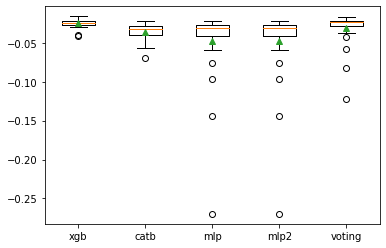

In [6]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, x_train_scaled, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores)*100, std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [7]:
#model

In [8]:
# fit the model on all available data
model.fit(x_train_scaled, y_train)
y_pred =model.predict(x_test_scaled)
mape_deger=mean_absolute_percentage_error(y_test,y_pred)

0:	learn: 16.1277545	total: 134ms	remaining: 2m 9s
1:	learn: 15.1209059	total: 136ms	remaining: 1m 5s
2:	learn: 14.2123656	total: 138ms	remaining: 44.1s
3:	learn: 13.2946613	total: 140ms	remaining: 33.5s
4:	learn: 12.4230388	total: 141ms	remaining: 27.1s
5:	learn: 11.6304622	total: 143ms	remaining: 22.8s
6:	learn: 10.9663291	total: 145ms	remaining: 19.7s
7:	learn: 10.2768313	total: 147ms	remaining: 17.5s
8:	learn: 9.6548744	total: 148ms	remaining: 15.7s
9:	learn: 9.1473804	total: 150ms	remaining: 14.3s
10:	learn: 8.5918622	total: 152ms	remaining: 13.1s
11:	learn: 8.1078207	total: 153ms	remaining: 12.1s
12:	learn: 7.6797084	total: 155ms	remaining: 11.3s
13:	learn: 7.1901765	total: 157ms	remaining: 10.6s
14:	learn: 6.7810136	total: 158ms	remaining: 10s
15:	learn: 6.3848407	total: 161ms	remaining: 9.49s
16:	learn: 6.0134955	total: 163ms	remaining: 9.04s
17:	learn: 5.6865337	total: 164ms	remaining: 8.62s
18:	learn: 5.3564866	total: 166ms	remaining: 8.24s
19:	learn: 5.0697177	total: 168ms	r

232:	learn: 0.4995932	total: 460ms	remaining: 1.44s
233:	learn: 0.4985590	total: 462ms	remaining: 1.44s
234:	learn: 0.4969242	total: 463ms	remaining: 1.43s
235:	learn: 0.4946255	total: 465ms	remaining: 1.43s
236:	learn: 0.4939565	total: 467ms	remaining: 1.43s
237:	learn: 0.4919276	total: 468ms	remaining: 1.42s
238:	learn: 0.4888227	total: 470ms	remaining: 1.42s
239:	learn: 0.4861655	total: 472ms	remaining: 1.42s
240:	learn: 0.4849141	total: 473ms	remaining: 1.42s
241:	learn: 0.4838061	total: 475ms	remaining: 1.41s
242:	learn: 0.4822999	total: 477ms	remaining: 1.41s
243:	learn: 0.4801570	total: 479ms	remaining: 1.41s
244:	learn: 0.4787067	total: 481ms	remaining: 1.41s
245:	learn: 0.4777212	total: 482ms	remaining: 1.4s
246:	learn: 0.4763428	total: 484ms	remaining: 1.4s
247:	learn: 0.4748667	total: 485ms	remaining: 1.4s
248:	learn: 0.4723143	total: 486ms	remaining: 1.39s
249:	learn: 0.4713202	total: 487ms	remaining: 1.39s
250:	learn: 0.4709598	total: 488ms	remaining: 1.38s
251:	learn: 0.4

475:	learn: 0.2459869	total: 785ms	remaining: 802ms
476:	learn: 0.2448726	total: 787ms	remaining: 800ms
477:	learn: 0.2447302	total: 789ms	remaining: 799ms
478:	learn: 0.2440612	total: 790ms	remaining: 797ms
479:	learn: 0.2436751	total: 792ms	remaining: 795ms
480:	learn: 0.2425057	total: 794ms	remaining: 794ms
481:	learn: 0.2421678	total: 796ms	remaining: 793ms
482:	learn: 0.2412494	total: 798ms	remaining: 791ms
483:	learn: 0.2404916	total: 800ms	remaining: 790ms
484:	learn: 0.2397897	total: 802ms	remaining: 788ms
485:	learn: 0.2389068	total: 803ms	remaining: 787ms
486:	learn: 0.2381917	total: 805ms	remaining: 785ms
487:	learn: 0.2373653	total: 806ms	remaining: 783ms
488:	learn: 0.2366049	total: 808ms	remaining: 781ms
489:	learn: 0.2361408	total: 809ms	remaining: 779ms
490:	learn: 0.2353216	total: 810ms	remaining: 777ms
491:	learn: 0.2351601	total: 811ms	remaining: 775ms
492:	learn: 0.2346146	total: 813ms	remaining: 773ms
493:	learn: 0.2343382	total: 814ms	remaining: 771ms
494:	learn: 

691:	learn: 0.1486826	total: 1.12s	remaining: 436ms
692:	learn: 0.1485422	total: 1.12s	remaining: 434ms
693:	learn: 0.1484480	total: 1.12s	remaining: 433ms
694:	learn: 0.1480280	total: 1.12s	remaining: 431ms
695:	learn: 0.1477083	total: 1.12s	remaining: 429ms
696:	learn: 0.1474589	total: 1.12s	remaining: 428ms
697:	learn: 0.1473345	total: 1.13s	remaining: 426ms
698:	learn: 0.1471778	total: 1.13s	remaining: 425ms
699:	learn: 0.1469702	total: 1.13s	remaining: 423ms
700:	learn: 0.1467198	total: 1.13s	remaining: 422ms
701:	learn: 0.1464553	total: 1.13s	remaining: 420ms
702:	learn: 0.1461492	total: 1.14s	remaining: 418ms
703:	learn: 0.1458432	total: 1.14s	remaining: 417ms
704:	learn: 0.1456958	total: 1.14s	remaining: 415ms
705:	learn: 0.1453816	total: 1.14s	remaining: 413ms
706:	learn: 0.1452139	total: 1.14s	remaining: 411ms
707:	learn: 0.1448113	total: 1.14s	remaining: 410ms
708:	learn: 0.1444795	total: 1.14s	remaining: 408ms
709:	learn: 0.1440200	total: 1.14s	remaining: 406ms
710:	learn: 

938:	learn: 0.0909354	total: 1.44s	remaining: 35.4ms
939:	learn: 0.0906747	total: 1.45s	remaining: 33.8ms
940:	learn: 0.0906005	total: 1.45s	remaining: 32.3ms
941:	learn: 0.0905469	total: 1.45s	remaining: 30.8ms
942:	learn: 0.0902218	total: 1.45s	remaining: 29.2ms
943:	learn: 0.0899705	total: 1.45s	remaining: 27.7ms
944:	learn: 0.0899087	total: 1.45s	remaining: 26.1ms
945:	learn: 0.0897431	total: 1.46s	remaining: 24.6ms
946:	learn: 0.0896265	total: 1.46s	remaining: 23.1ms
947:	learn: 0.0894448	total: 1.46s	remaining: 21.5ms
948:	learn: 0.0894049	total: 1.46s	remaining: 20ms
949:	learn: 0.0893441	total: 1.46s	remaining: 18.5ms
950:	learn: 0.0892526	total: 1.46s	remaining: 16.9ms
951:	learn: 0.0892209	total: 1.47s	remaining: 15.4ms
952:	learn: 0.0890994	total: 1.47s	remaining: 13.9ms
953:	learn: 0.0889095	total: 1.47s	remaining: 12.3ms
954:	learn: 0.0887257	total: 1.47s	remaining: 10.8ms
955:	learn: 0.0884741	total: 1.47s	remaining: 9.23ms
956:	learn: 0.0882510	total: 1.47s	remaining: 7.

In [9]:
mape_deger*100

1.6973523771373484